In [106]:
from datetime import datetime
import pandas as pd
from geopy import distance
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from sklearn.model_selection import cross_validate




import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [2]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']
in_coll = db['labeled_trips']
coll = db['trips']

In [24]:
duration_cursor = coll.find({}, {'_id': 0, 'trip_duration': 1, 'first_timestamp': 1}).sort('first_timestamp')

In [25]:
ts = []
duration = []

for trip_deets in duration_cursor:
    ts.append(trip_deets['first_timestamp'])
    duration.append(trip_deets['trip_duration'])

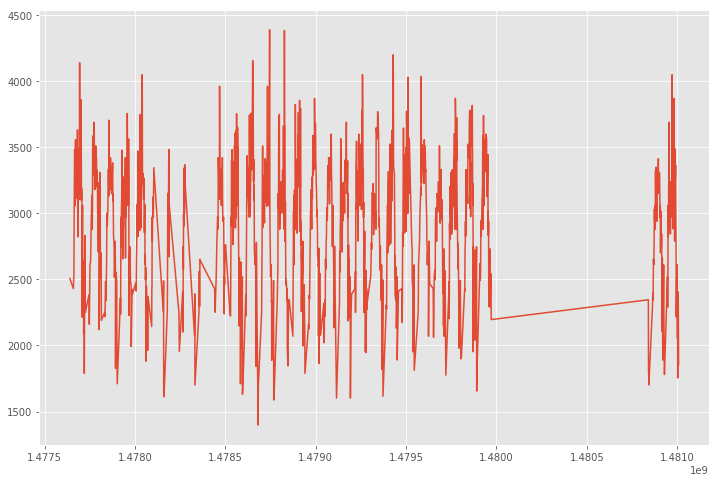

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, duration);

In [4]:
coll.find_one()

{'_id': '7253717_2016-10-28_HKH3O',
 'edges': {'1': {'sequence': 1,
   'from': 6293,
   'to': 3879,
   'first_timestamp': 1477639677.0,
   'last_timestamp': 1477639765.0,
   'edge_time': 88.0},
  '2': {'sequence': 2,
   'from': 3879,
   'to': 3852,
   'first_timestamp': 1477639765.0,
   'last_timestamp': 1477639811.0,
   'edge_time': 46.0},
  '3': {'sequence': 3,
   'from': 3852,
   'to': 3644,
   'first_timestamp': 1477639811.0,
   'last_timestamp': 1477639857.0,
   'edge_time': 46.0},
  '4': {'sequence': 4,
   'from': 3644,
   'to': 3645,
   'first_timestamp': 1477639857.0,
   'last_timestamp': 1477639939.0,
   'edge_time': 82.0},
  '5': {'sequence': 5,
   'from': 3645,
   'to': 3649,
   'first_timestamp': 1477639939.0,
   'last_timestamp': 1477639993.0,
   'edge_time': 54.0},
  '6': {'sequence': 6,
   'from': 3649,
   'to': 3642,
   'first_timestamp': 1477639993.0,
   'last_timestamp': 1477640065.0,
   'edge_time': 72.0},
  '7': {'sequence': 7,
   'from': 3642,
   'to': 4224,
   'fi

I want edges 11, 12, 13, and 14 (trying to predict 14)
I also want stops 11, 12 and 13

In [148]:
projection = {
    '_id': 0, 
    'edges.11.edge_time': 1, 
    'edges.12.edge_time': 1,
    'edges.13.edge_time': 1,
    'edges.14.edge_time': 1,
    'stops.11.seconds_at_stop': 1,
    'stops.12.seconds_at_stop': 1,
    'stops.13.seconds_at_stop': 1,
    'midday': 1,
    'rush_hour': 1,
    'weekend': 1
    }

feature_array = []
label_array = []

for trip_item in coll.find({}, projection):
    
    label = trip_item['edges']['14']['edge_time']
    label_array.append(label)
    
    trip_details = []
    edg11 = trip_item['edges']['11']['edge_time']
    edg12 = trip_item['edges']['12']['edge_time']
    edg13 = trip_item['edges']['13']['edge_time']
    
    wknd = trip_item['weekend']
    rhhr = trip_item['rush_hour']
    mddy = trip_item['midday']
    
#     stp11 = trip_item['stops']['11']['seconds_at_stop']
#     stp12 = trip_item['stops']['12']['seconds_at_stop']
#     stp13 = trip_item['stops']['13']['seconds_at_stop']
    
#     trip_details.extend([edg11, edg12, edg13, stp11, stp12, stp13])

#     trip_details.extend([edg11, edg12, edg13])
    
    trip_details.extend([edg11, edg12, edg13, wknd, rhhr, mddy])
    
    feature_array.append(trip_details)
    

X = np.array(feature_array)
y = np.array(label_array).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [149]:
ols = LinearRegression()

In [150]:
ols.fit(X_train, y_train);

In [151]:
ols.score(X_test, y_test)

0.061549323566388196

In [152]:
ols.coef_

array([[-0.16425639, -0.27971793, -0.29769995, 10.91211844, 17.06664323,
        26.91955635]])

In [153]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     87.97
Date:                Tue, 01 May 2018   Prob (F-statistic):           1.69e-87
Time:                        19:20:46   Log-Likelihood:                -5207.8
No. Observations:                 944   AIC:                         1.043e+04
Df Residuals:                     938   BIC:                         1.046e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1365      0.030      4.619      0.000       0.079       0.195
x2            -0.0055      0.035     -0.157      0.875      -0.074       0.063
x3             0.0126      0.041      0.309      0.758      -0.068       0.093
x4            17.2102      4.416      3.897      0.000       8.544      25.877
x5            28.7496      4.891      5.878      0.000      19.151      38.348
x6            34.8906      5.084      6.863      0.000      24.914      44.867
==============================================================================
Omnibus:                     1279.195   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           217768.835
Skew:                           7.377   Prob(JB):                         0.00
Kurtosis:                      75.930   Cond. No.                         479.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [155]:
regr.score(X_test, y_test.flatten())

-0.4166196867902215

In [156]:
this = regr.predict(X_test)

In [157]:
this.shape

(315,)

In [158]:
hello = y_test.flatten()

In [159]:
hello.shape

(315,)

In [160]:
cheers = abs(this - hello)

In [102]:
cheers.mean()

22.439838135602486

In [103]:
y.shape

(1259, 1)

In [104]:
y.flatten().mean()

48.72120730738681

## Normalize?

In [161]:
X_norm = normalize(X)
y_norm = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25)

In [162]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     9162.
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        19:21:30   Log-Likelihood:                 600.07
No. Observations:                 944   AIC:                            -1188.
Df Residuals:                     938   BIC:                            -1159.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7845      0.013     61.085      0.000       0.759       0.810
x2             0.5527      0.014     39.175      0.000       0.525       0.580
x3             0.4011      0.018     22.757      0.000       0.366       0.436
x4             0.6729      0.136      4.965      0.000       0.407       0.939
x5             0.9648      0.071     13.541      0.000       0.825       1.105
x6             0.5195      0.051     10.099      0.000       0.419       0.620
==============================================================================
Omnibus:                      601.344   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22228.202
Skew:                          -2.334   Prob(JB):                         0.00
Kurtosis:                      26.309   Cond. No.                         30.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
sm_predict = results.predict(X_test)

In [164]:
from sklearn.metrics import r2_score

In [165]:
r2_score(y_test, sm_predict.reshape(-1,1))

0.35726604591311517

In [169]:
sm_predict.reshape(-1,1)

array([[0.99471085],
       [1.02100264],
       [1.00075555],
       [1.00686217],
       [1.03870696],
       [1.01115782],
       [1.0092302 ],
       [1.02225105],
       [1.03323046],
       [1.03937143],
       [1.01974511],
       [0.97598704],
       [0.99544851],
       [1.03199561],
       [1.02239495],
       [1.0221315 ],
       [1.018244  ],
       [1.0269618 ],
       [1.00971908],
       [0.96701015],
       [1.03362514],
       [0.78689353],
       [1.02970228],
       [0.99023579],
       [1.02798905],
       [1.04354442],
       [1.01522506],
       [1.03132139],
       [1.02711821],
       [1.04157637],
       [0.78584085],
       [0.97797308],
       [1.03743493],
       [1.02468717],
       [0.98212493],
       [1.05283983],
       [0.98804772],
       [1.03528135],
       [1.00971908],
       [1.03408568],
       [1.01992167],
       [1.00890288],
       [0.96111282],
       [1.01083242],
       [1.02561456],
       [1.01343404],
       [1.01635436],
       [1.009

In [172]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_test, y_test)

0.303486938530953

In [173]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.27882656751680013

# With new temporal fields

In [271]:
projection = {
    '_id': 0, 
    'edges.11.edge_time': 1, 
    'edges.12.edge_time': 1,
    'edges.13.edge_time': 1,
    'edges.14.edge_time': 1,
    'stops.11.seconds_at_stop': 1,
    'stops.12.seconds_at_stop': 1,
    'stops.13.seconds_at_stop': 1,
    'minutes_from_noon_sqr': 1,
    'midday': 1,
    'rush_hour': 1,
    'weekend': 1
    }

feature_array = []
label_array = []

for trip_item in coll.find({}, projection):
    
    label = trip_item['edges']['14']['edge_time']
    label_array.append(label)
    
    trip_details = []
    edg11 = trip_item['edges']['11']['edge_time']
    edg12 = trip_item['edges']['12']['edge_time']
    edg13 = trip_item['edges']['13']['edge_time']
    
    temporal = trip_item['minutes_from_noon_sqr']
    
    stp11 = trip_item['stops']['11']['seconds_at_stop']
    stp12 = trip_item['stops']['12']['seconds_at_stop']
    stp13 = trip_item['stops']['13']['seconds_at_stop']
    
    wknd = trip_item['weekend']
    rhhr = trip_item['rush_hour']
    mddy = trip_item['midday']
    
#     trip_details.extend([edg11, edg12, edg13, stp11, stp12, stp13, temporal,
#                         wknd, rhhr, mddy])

#     trip_details.extend([edg11, edg12, edg13, temporal,
#                         wknd, rhhr, mddy])

#     trip_details.extend([edg11, edg12, edg13])
    
    trip_details.extend([edg11, edg12, edg13, temporal])

#     trip_details.extend([temporal])
    
    feature_array.append(trip_details)
    

X = np.array(feature_array)
y = np.array(label_array).reshape(-1, 1)

In [272]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_norm = normalize(X)
# y_norm = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [273]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     20.01
Date:                Tue, 01 May 2018   Prob (F-statistic):           7.86e-16
Time:                        20:04:23   Log-Likelihood:                -1116.4
No. Observations:                 944   AIC:                             2241.
Df Residuals:                     940   BIC:                             2260.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0869      0.028     -3.095      0.002      -0.142      -0.032
x2            -0.1573      0.025     -6.339      0.000      -0.206      -0.109
x3            -0.1679      0.026     -6.468      0.000      -0.219      -0.117
x4            -0.1191      0.027     -4.390      0.000      -0.172      -0.066
==============================================================================
Omnibus:                     1247.930   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209336.729
Skew:                           7.032   Prob(JB):                         0.00
Kurtosis:                      74.584   Cond. No.                         1.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [281]:
regr = RandomForestRegressor(n_estimators=50, max_depth=3, max_features=2)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.829034010489103
RMSE:  98.29631037437326


In [192]:
cursor = coll.find({}, projection)
out_lst = []
for hella in cursor:
    row = {}
    row['edg_11'] = hella['edges']['11']['edge_time']
    row['edg_12'] = hella['edges']['12']['edge_time']
    row['edg_13'] = hella['edges']['13']['edge_time']
    row['temporal'] = hella['minutes_from_noon_sqr']
    out_lst.append(row)

In [193]:
df = pd.DataFrame(list(out_lst))

In [195]:
df

,edg_11,edg_12,edg_13,temporal
0,112.0,66.0,52.0,480249
1,122.0,102.0,46.0,63001
2,130.0,62.0,38.0,146689
3,120.0,76.0,34.0,265225
4,134.0,60.0,36.0,394384
5,90.0,90.0,65.0,12544
6,180.0,90.0,52.0,784
7,180.0,180.0,80.0,28561
8,180.0,90.0,90.0,96100
9,90.0,90.0,90.0,202500


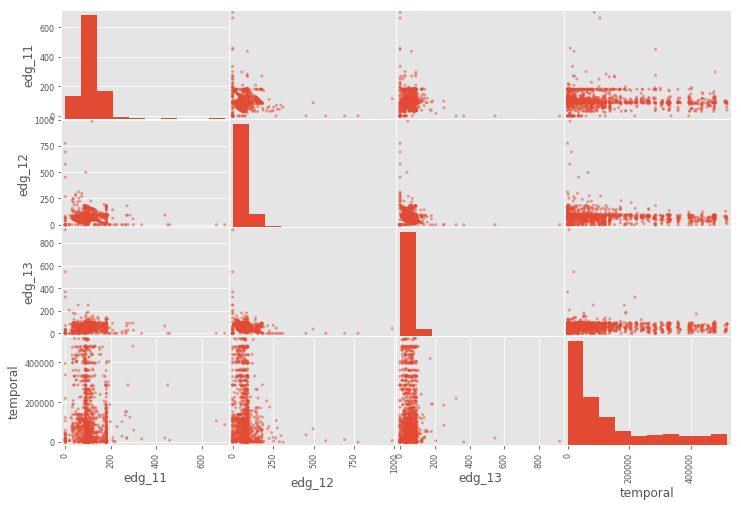

In [94]:
pd.plotting.scatter_matrix(df, figsize=(12,8));

In [287]:
projection = {
    '_id': 0, 
    'edges.11.edge_time': 1, 
    'edges.12.edge_time': 1,
    'edges.13.edge_time': 1,
    'edges.14.edge_time': 1,
    'stops.11.seconds_at_stop': 1,
    'stops.12.seconds_at_stop': 1,
    'stops.13.seconds_at_stop': 1,
    'minutes_from_noon_sqr': 1,
    'midday': 1,
    'rush_hour': 1,
    'weekend': 1
    }

feature_array = []
label_array = []

for trip_item in coll.find({}, projection):
    
    label = trip_item['edges']['14']['edge_time']
    label_array.append(label)
    
    trip_details = []
    edg11 = trip_item['edges']['11']['edge_time']
    edg12 = trip_item['edges']['12']['edge_time']
    edg13 = trip_item['edges']['13']['edge_time']
    
    temporal = trip_item['minutes_from_noon_sqr']
    
    stp11 = trip_item['stops']['11']['seconds_at_stop']
    stp12 = trip_item['stops']['12']['seconds_at_stop']
    stp13 = trip_item['stops']['13']['seconds_at_stop']
    
    wknd = trip_item['weekend']
    rhhr = trip_item['rush_hour']
    mddy = trip_item['midday']
    
    trip_details.extend([temporal])
    
    feature_array.append(trip_details)
    

X = np.array(feature_array).reshape(-1, 1)
y = np.array(label_array).reshape(-1, 1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)


regr = RandomForestRegressor(n_estimators=50, max_depth=2)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


R-squared:  -1.0245377008611436
RMSE:  103.83260483493405


In [302]:
coll.find_one()

{'_id': '7253717_2016-10-28_HKH3O',
 'edges': {'1': {'sequence': 1,
   'from': 6293,
   'to': 3879,
   'first_timestamp': 1477639677.0,
   'last_timestamp': 1477639765.0,
   'edge_time': 88.0,
   'normed_edge': 0.03054876832136479},
  '2': {'sequence': 2,
   'from': 3879,
   'to': 3852,
   'first_timestamp': 1477639765.0,
   'last_timestamp': 1477639811.0,
   'edge_time': 46.0,
   'normed_edge': -0.5781219806403038},
  '3': {'sequence': 3,
   'from': 3852,
   'to': 3644,
   'first_timestamp': 1477639811.0,
   'last_timestamp': 1477639857.0,
   'edge_time': 46.0,
   'normed_edge': -0.5882779366843017},
  '4': {'sequence': 4,
   'from': 3644,
   'to': 3645,
   'first_timestamp': 1477639857.0,
   'last_timestamp': 1477639939.0,
   'edge_time': 82.0,
   'normed_edge': 0.4019999036617356},
  '5': {'sequence': 5,
   'from': 3645,
   'to': 3649,
   'first_timestamp': 1477639939.0,
   'last_timestamp': 1477639993.0,
   'edge_time': 54.0,
   'normed_edge': -0.0995643092431499},
  '6': {'sequenc

In [313]:
in_coll = db['avl_raw']
search = {
    'VEHICLE_TAG': '5405',
    'TRAIN_ASSIGNMENT': '3305'
   
}

interval = list(in_coll.find(search).sort("time_stamp").limit(100))

In [326]:
hella_lst = list(in_coll.find({'VEHICLE_TAG':{'$ne': '5405'}}).limit(100))

In [327]:
hella_lst

[{'_id': ObjectId('5ae4d96e3ad39e17213bebcb'),
  'time_stamp': 1480946829.0,
  'REV': '1526',
  'REPORT_TIME': '12/05/2016 06:07:09',
  'VEHICLE_TAG': '5411',
  'LONGITUDE': '-122.43542',
  'LATITUDE': '37.7609',
  'SPEED': '1.389',
  'HEADING': '261.0',
  'TRAIN_ASSIGNMENT': '3303',
  'PREDICTABLE': '1'},
 {'_id': ObjectId('5ae4d96e3ad39e17213bebcc'),
  'time_stamp': 1480946835.0,
  'REV': '1526',
  'REPORT_TIME': '12/05/2016 06:07:15',
  'VEHICLE_TAG': '5411',
  'LONGITUDE': '-122.43584',
  'LATITUDE': '37.76085',
  'SPEED': '6.667',
  'HEADING': '265.0',
  'TRAIN_ASSIGNMENT': '3303',
  'PREDICTABLE': '1'},
 {'_id': ObjectId('5ae4d96e3ad39e17213bebcd'),
  'time_stamp': 1480946867.0,
  'REV': '1526',
  'REPORT_TIME': '12/05/2016 06:07:47',
  'VEHICLE_TAG': '5411',
  'LONGITUDE': '-122.438',
  'LATITUDE': '37.76072',
  'SPEED': '7.5',
  'HEADING': '265.0',
  'TRAIN_ASSIGNMENT': '3303',
  'PREDICTABLE': '1'},
 {'_id': ObjectId('5ae4d96e3ad39e17213bebce'),
  'time_stamp': 1480946905.0,
 

In [328]:
thrilla = []

for idx, item in enumerate(interval):
    if idx != 99:
        dt_1 = datetime.fromtimestamp(item['time_stamp'])
        dt_2 = datetime.fromtimestamp(interval[idx+1]['time_stamp'])
        
        diff = dt_2 - dt_1
        
        thrilla.append(diff.total_seconds())
        

In [316]:
np.array(thrilla).mean()

43.93939393939394

In [317]:
np.std(thrilla)

33.463327788840694

In [358]:
in_coll = db['avl_raw']
search = {
    'time_stamp': {'$gt': 1480957269.0},
    'VEHICLE_TAG': '5411',
    'TRAIN_ASSIGNMENT': '3303' 
}

interval_2 = list(in_coll.find(search).sort("time_stamp").limit(100))

thrilla_2 = []

for idx, item in enumerate(interval_2):
    if idx != 99:
        dt_1 = datetime.fromtimestamp(item['time_stamp'])
        dt_2 = datetime.fromtimestamp(interval_2[idx+1]['time_stamp'])
        
        diff = dt_2 - dt_1
        
        thrilla_2.append(diff.total_seconds())

In [359]:
np.array(thrilla_2).mean()

44.7979797979798